In [1]:
# /// script
# requires-python = ">=3.11"
# ///
from pathlib import Path
from datetime import datetime
import numpy as np
from PIL import Image
import imageio
import skimage
import pooch

import matplotlib.pyplot as plt
%matplotlib inline

# *Intro to image segmentation – Global BioImaging Data Course - Pune, India*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HMS-IAC/GBI-india/blob/main/notebooks/03_Intro_to_Segmentation.ipynb)


Welcome to the image segmentation chapter!  
Just like the previous notebook, it is **an interactive book**: read, explore, and **do**.

You will learn **core building blocks**:

| Chapter | Concept | Why it matters |
|---------|---------|----------------|
| 0 | What is *image segmentation*? | Semantics vs instance segmentation |
| 1 | Gaussian smoothing + Otsu threshold | Simple foreground / background separation |
| 2 | Watershed | Split touching objects into individual pieces |

Each chapter follows the same pattern:



---
## 0. What is *image segmentation*?

**Segmentation** means labeling each pixel so that we can tell *which pile of pixels belongs to which real‑world object*.

There are two main types of segmentation:
* **Semantic segmentation**: Label each pixel with its class (e.g. "stroma", "cytoplasm", "background"). Good for tissues.
* **Instance segmentation**: Label each pixel with a unique ID for each object (e.g. "cell 1", "cell 2" or "nucleus 1", "nucleus 2"). Good for cell-based analysis.

In bioimage analysis that usually means turning a fluorescence snapshot into a **binary mask** of some cellular, subcellular, or tissue structure. Once you have a mask you can measure size, shape, intensity, count cells, follow them over time – all the good stuff.

There are many ways to segment.  
Today we will cover two classical yet powerful techniques that get you surprisingly far:

| Chapter | Technique | Typical use‑case |
|---------|-----------|------------------|
| 1 | Gaussian + Otsu threshold | Simple foreground / background separation |
| 2 | Watershed | Split touching objects into individual pieces |

Each chapter follows the same pattern:

1. **Theory** – short, intuitive overview (no equations needed).
2. **Live demo** – run the code and poke at the parameters.
3. **Your turn** – exercises marked with ✍️ to make you write code.

Ready? Scroll on!


---
## 1. Gaussian smoothing + Otsu threshold

### 1.1 Intuition

Real microscope images are *noisy*.  
Noisy pixels can trick a thresholding algorithm, and also sometimes we don't want to detect small details, so we **smooth** the image first with a *Gaussian blur* from `skimage.filters.gaussian_filter`:

```python
clean = gaussian(image, sigma)
```

* `sigma` ≈ size of the noise blobs (in pixels).
* Big `sigma` ⟶ more blur, fewer details.

Then we separate foreground & background using **Otsu’s method** (`skimage.filters.threshold_otsu`).  
Otsu finds the threshold that minimises the variance *inside* each class while maximising the variance *between* classes – no parameter to tune!

Finally we create a **binary mask**:

```python
mask = clean > thresh
```

That’s it – three lines for a first segmentation pass.


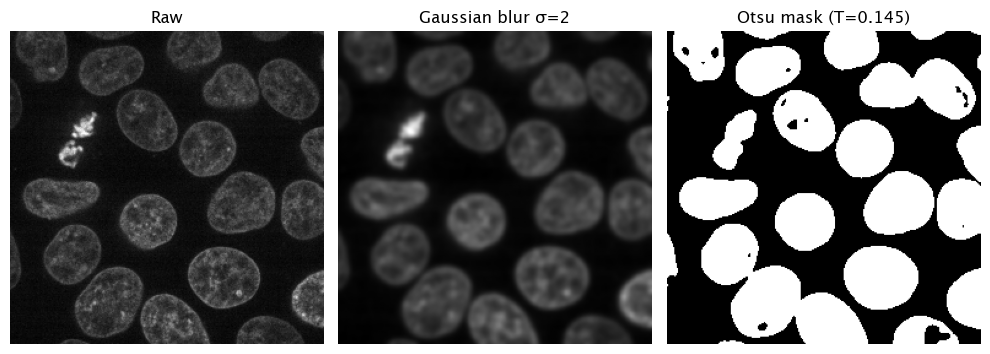

In [45]:
# ## Live demo – segment nuclei in a fluorescence image
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, remove_small_holes

# 1) Load example image (grayscale)
image_rgb = data.cells3d()[30, 1]  # Z‑slice 30, channel 1 (DNA stain)
image = img_as_float(image_rgb)

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Raw')

# 2) Smooth
sigma = 2
smooth = gaussian(image, sigma=sigma)
ax[1].imshow(smooth, cmap='gray')
ax[1].set_title(f'Gaussian blur σ={sigma}')

# 3) Otsu threshold
thresh = filters.threshold_otsu(smooth)
mask = smooth > thresh

ax[2].imshow(mask, cmap='gray')
ax[2].set_title(f'Otsu mask (T={thresh:.3f})')

for a in ax: a.axis('off')
plt.tight_layout()


### ✍️ Exercise: your turn!

1. Re‑run the cell above with **different `sigma` values** (try 0.5, 1, 4, 8).  
   *How does blur influence the threshold and the mask?*
2. 🏆 *Challenge:* compute the **percentage of pixels** classified as foreground for each `sigma` and plot `sigma` vs `% foreground`.

Extra point if you use a for loop!


_Add extra cells below – the notebook is your sandbox!_


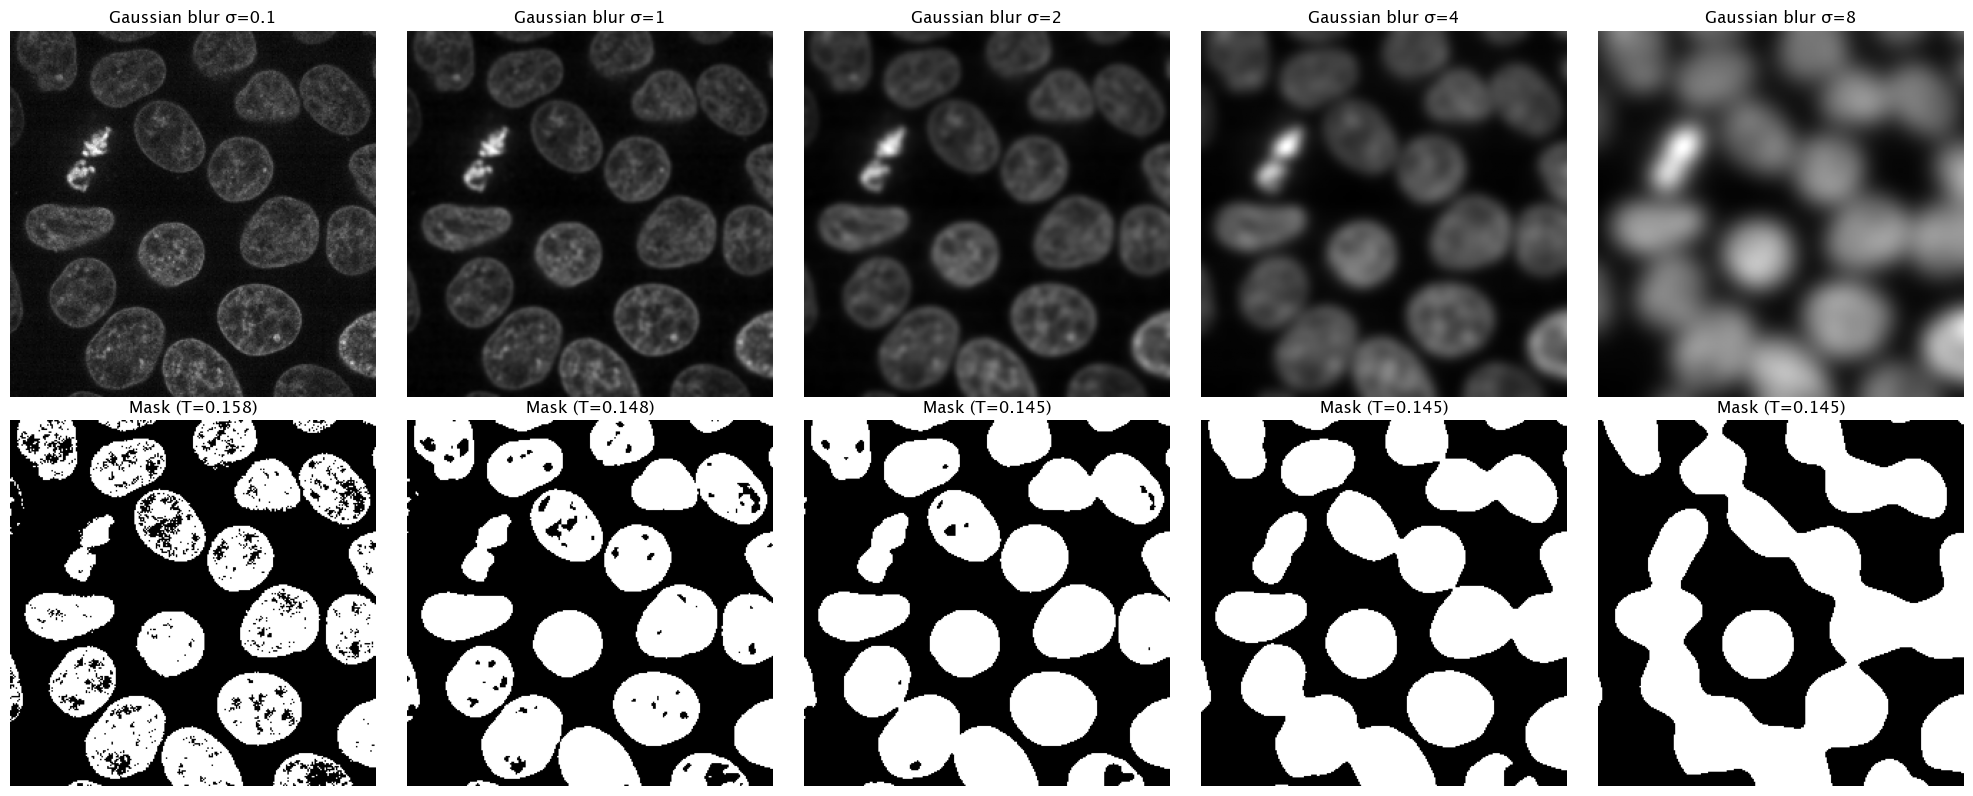

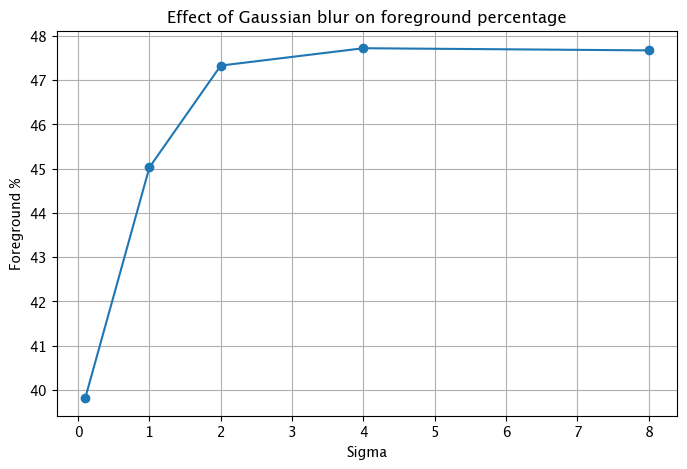

In [46]:
# solution to exercise 1

# Import additional required functions
from skimage.morphology import binary_opening, binary_closing

# Try different sigma values and store foreground percentages
sigmas = [0.1, 1, 2, 4, 8]
foreground_pcts = []

fig, axes = plt.subplots(2, len(sigmas), figsize=(20, 8))
for i, sigma in enumerate(sigmas):
    # smooth
    smooth = gaussian(image, sigma=sigma)

    # find threshold with otsu
    thresh = filters.threshold_otsu(smooth)
    mask = smooth > thresh
    
    # calculate foreground percentage
    foreground_pct = 100 * np.sum(mask) / mask.size
    foreground_pcts.append(foreground_pct)
    
    # plot results
    axes[0,i].imshow(smooth, cmap='gray')
    axes[0,i].set_title(f'Gaussian blur σ={sigma}')
    axes[0,i].axis('off')
    
    axes[1,i].imshow(mask, cmap='gray')
    axes[1,i].set_title(f'Mask (T={thresh:.3f})')
    axes[1,i].axis('off')

plt.tight_layout()

# Plot sigma vs foreground percentage
plt.figure(figsize=(8,5))
plt.plot(sigmas, foreground_pcts, 'o-')
plt.xlabel('Sigma')
plt.ylabel('Foreground %')
plt.title('Effect of Gaussian blur on foreground percentage')
plt.grid(True)
plt.show()


Noticing all the little speckles in the mask? We can use morphological operations to clean it up:
1. Add a **morphological opening** (`skimage.morphology.binary_opening`) before `remove_small_objects` to get rid of speckles.
2. Add a **morphological closing** (`skimage.morphology.binary_closing`) after `remove_small_objects` to fill holes.

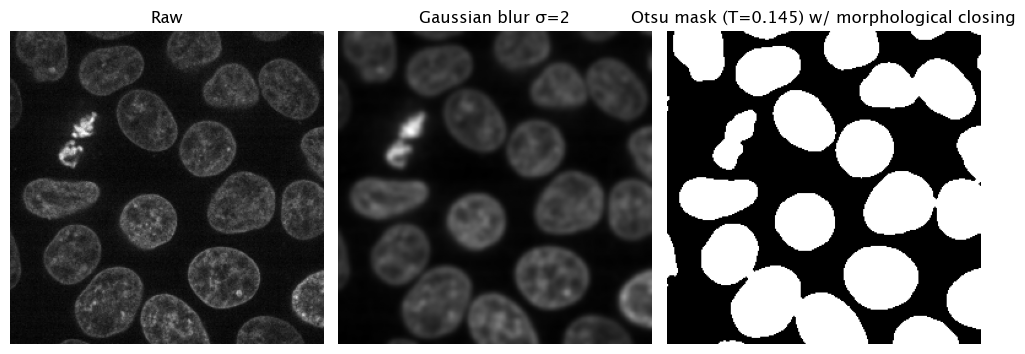

In [106]:
# ## Live demo – segment nuclei in a fluorescence image
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.morphology import binary_closing, remove_small_holes

# 1) Load example image (grayscale)
image_rgb = data.cells3d()[30, 1]  # Z‑slice 30, channel 1 (DNA stain)
image = img_as_float(image_rgb)

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Raw')

# 2) Smooth
sigma = 2
smooth = gaussian(image, sigma=sigma)
ax[1].imshow(smooth, cmap='gray')
ax[1].set_title(f'Gaussian blur σ={sigma}')

# 3) Otsu threshold
thresh = filters.threshold_otsu(smooth)
mask = smooth > thresh

# 4) Morphological operations
mask = remove_small_holes(mask, 1000)
mask = binary_closing(mask)

ax[2].imshow(mask, cmap='gray')
ax[2].set_title(f'Otsu mask (T={thresh:.3f}) w/ morphological closing')

for a in ax: a.axis('off')
plt.tight_layout()


---
## 2. Watershed – separating touching objects

### 2.1 Intuition

Imagine the grayscale image as a topographic surface:

* Bright pixels are **hills**, dark pixels are **valleys**.
* We punch *markers* in the valleys we know belong to different objects.
* Then we **flood** the landscape – water rises simultaneously from every marker.
* Where waters meet we build a dam → that becomes the *watershed line* separating objects.

![Watershed segmentation intuition showing how water rises from markers to create watershed lines](data/image.png)

In practice we often:

1. Compute a **distance transform** of the binary mask (distance to nearest background pixel).  
   Peaks of this map lie at object centres.
2. Find **local maxima** of the distance map as markers.
3. Run `skimage.segmentation.watershed` on the **negative distance map** so water flows from centres to edges.


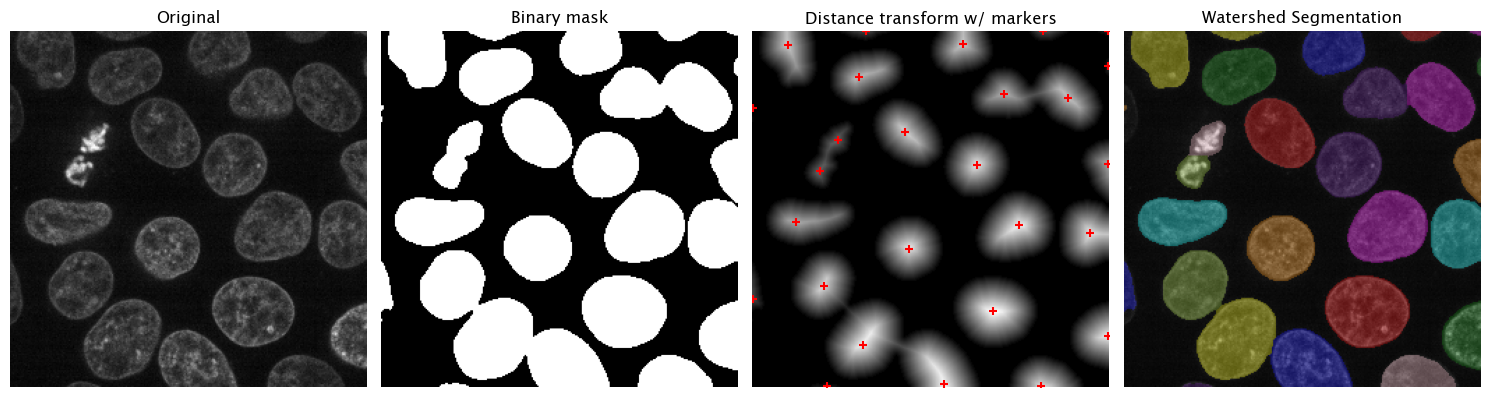

In [113]:
# ## Live demo – split clustered nuclei
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, segmentation, measure, color
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

# Step 1: Smooth and threshold
blurred = filters.gaussian(image, sigma=2)
binary = blurred > filters.threshold_otsu(blurred)
binary = remove_small_holes(binary, 300)

# Step 2: Compute distance transform
distance = ndi.distance_transform_edt(binary)

# Step 3: Find well-separated peaks
# Use a min_distance to suppress close peaks in same object
coordinates = peak_local_max(
    distance,
    labels=binary,
    min_distance=20,       # <-- adjust this value!
    exclude_border=False,
    footprint=np.ones((10, 10)),
)

# Step 4: Generate markers from peaks
markers = np.zeros_like(distance, dtype=int)
for i, coord in enumerate(coordinates, 1):
    markers[tuple(coord)] = i

# Step 5: Apply Watershed on the negative distance map
labels = segmentation.watershed(-distance, markers, mask=binary)

# Step 6: Visualize results
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(binary, cmap='gray')
axes[1].set_title("Binary mask")
axes[2].imshow(distance, cmap='gray')
axes[2].set_title("Distance transform w/ markers")
axes[2].imshow(distance, cmap='gray')
axes[2].scatter(coordinates[:, 1], coordinates[:, 0], c='red', marker='+')
axes[3].imshow(color.label2rgb(labels, image=image, bg_label=0))
axes[3].set_title("Watershed Segmentation")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()


### ✍️ Exercise: your turn!
1. Change the `min_distance` in `peak_local_max`.  
   *Smaller `min_distance` ⇒ more markers ⇒ over‑segmentation.*
2. Use **`skimage.morphology.watershed`** on the *gradient magnitude* (e.g. Sobel filter) instead of the distance map.  
   Compare results.
3. 🏆 *Challenge:* compute **area distribution** of segmented objects and plot a histogram. Mark the mean and median.

_Extra cell slots below – go wild!_


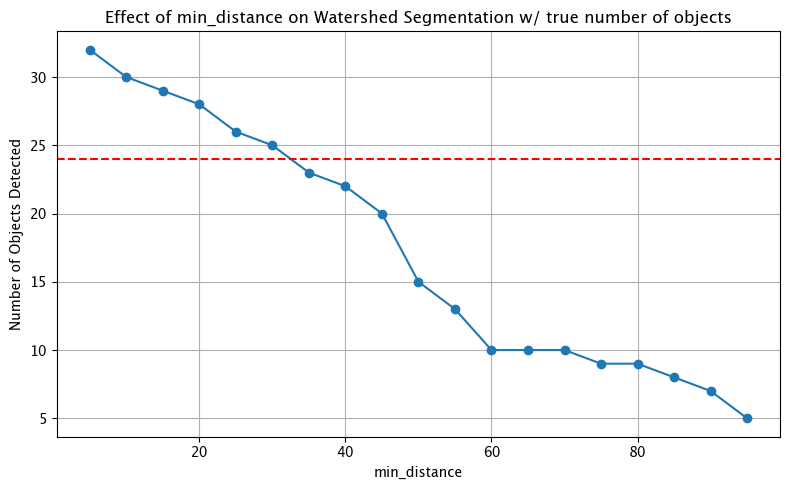

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, segmentation, color, morphology, measure
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

# Load image
blurred = filters.gaussian(image, sigma=1.0)
binary = blurred > filters.threshold_otsu(blurred)
binary = remove_small_holes(binary, 300)
distance = ndi.distance_transform_edt(binary)

# Sweep over different min_distance values
min_distances = range(5, 100, 5)
object_counts = []

for min_dist in min_distances:
    # Get peaks with current min_distance
    coordinates = peak_local_max(
        distance,
        labels=binary,
        min_distance=min_dist,
        exclude_border=False,
        footprint=np.ones((10, 10))
    )

    # Create markers
    markers = np.zeros_like(distance, dtype=int)
    for i, coord in enumerate(coordinates, 1):
        markers[tuple(coord)] = i

    # Watershed
    labels_ws = segmentation.watershed(-distance, markers, mask=binary)
    
    # Count objects (connected components)
    num_objects = len(measure.regionprops(labels_ws))
    object_counts.append(num_objects)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(min_distances, object_counts, marker='o')
plt.axhline(24, color='r', linestyle='dashed')
plt.xlabel('min_distance')
plt.ylabel('Number of Objects Detected')
plt.title('Effect of min_distance on Watershed Segmentation w/ true number of objects')
plt.grid(True)
plt.tight_layout()
plt.show()


---
## 3. Take‑aways

* **Gaussian + Otsu** is a great first‑pass for foreground/background.
* **Watershed** excels at splitting merged blobs when you give it good markers.
* The key is still **pre‑processing** and **parameter tuning** – there is no one‑click solution.

In the next notebook we will explore **machine‑learning‑based** segmentation that learns the parameters for us. Stay tuned!

---
